c:\Users\itsay\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP (Raw) Results:
  MSE: 2061.654861313731
  R²: 0.8952141068456215


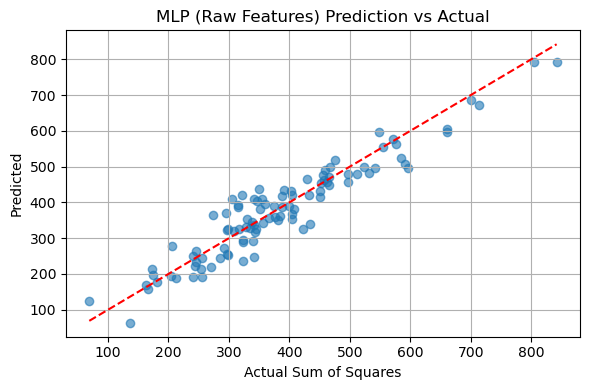

In [5]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

train_df = pd.read_csv("train_4x4_eigen_data.csv")
test_df = pd.read_csv("test_4x4_eigen_data.csv")

raw_features = [chr(97 + i) for i in range(16)]  # ['a', 'b', ..., 'p']
X_train = train_df[raw_features]
y_train = train_df['sum_squared']
X_test = test_df[raw_features]
y_test = test_df['sum_squared']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

mlp_raw = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
mlp_raw.fit(X_train_scaled, y_train)

y_pred_raw = mlp_raw.predict(X_test_scaled)
print("MLP (Raw) Results:")
print("  MSE:", mean_squared_error(y_test, y_pred_raw))
print("  R²:", r2_score(y_test, y_pred_raw))

plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_raw, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Sum of Squares")
plt.ylabel("Predicted")
plt.title("MLP (Raw Features) Prediction vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()



MLP Regressor (Enhanced 4x4):
  MSE: 1149.16
  R²:  0.9416


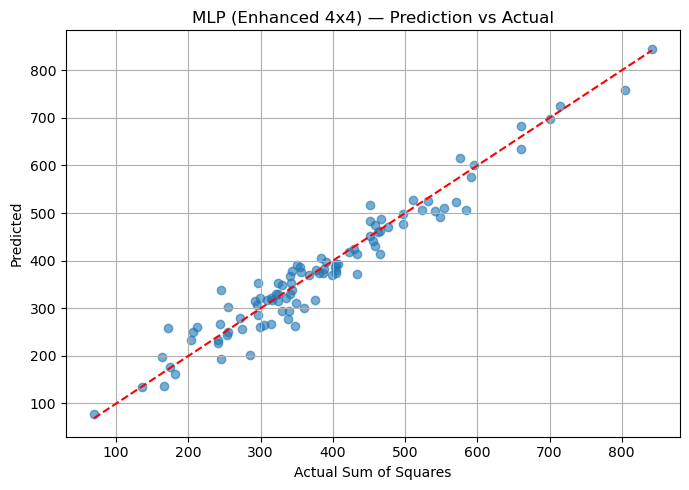

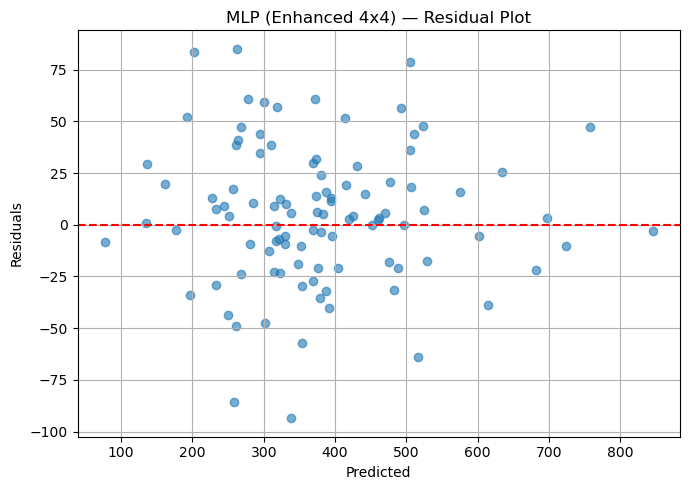

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

def add_features(df):
    df['trace'] = df['a'] + df['f'] + df['k'] + df['p']

    def symmetry_score(row):
        mat = np.array([
            [row['a'], row['b'], row['c'], row['d']],
            [row['e'], row['f'], row['g'], row['h']],
            [row['i'], row['j'], row['k'], row['l']],
            [row['m'], row['n'], row['o'], row['p']],
        ])
        score = 0
        for i in range(4):
            for j in range(i + 1, 4):
                score += abs(mat[i][j] - mat[j][i])
        return score

    def det_4x4(row):
        mat = np.array([
            [row['a'], row['b'], row['c'], row['d']],
            [row['e'], row['f'], row['g'], row['h']],
            [row['i'], row['j'], row['k'], row['l']],
            [row['m'], row['n'], row['o'], row['p']]
        ])
        return np.linalg.det(mat)

    df['sym_score'] = df.apply(symmetry_score, axis=1)
    df['det'] = df.apply(det_4x4, axis=1)
    return df

train_df = add_features(pd.read_csv('train_4x4_eigen_data.csv'))
test_df = add_features(pd.read_csv('test_4x4_eigen_data.csv'))

feature_cols = list("abcdefghijklmnop") + ['trace', 'sym_score', 'det']
X_train = train_df[feature_cols]
y_train = train_df['sum_squared']
X_test = test_df[feature_cols]
y_true = test_df['sum_squared']

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

mlp = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
mlp.fit(X_train_scaled, y_train)
y_pred = mlp.predict(X_test_scaled)

mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"\nMLP Regressor (Enhanced 4x4):")
print(f"  MSE: {mse:.2f}")
print(f"  R²:  {r2:.4f}")

test_df['predicted_sum_squared'] = y_pred
test_df.to_csv('test_4x4_eigen_data.csv', index=False)

plt.figure(figsize=(7, 5))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.xlabel("Actual Sum of Squares")
plt.ylabel("Predicted")
plt.title("MLP (Enhanced 4x4) — Prediction vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()

residuals = y_true - y_pred
plt.figure(figsize=(7, 5))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("MLP (Enhanced 4x4) — Residual Plot")
plt.grid(True)
plt.tight_layout()
plt.show()
